Singular values: [1.00000000e+02 1.29154967e+01 1.66810054e+00 2.15443469e-01
 2.78255940e-02 3.59381366e-03 4.64158883e-04 5.99484250e-05
 7.74263683e-06 1.00000000e-06]

Checkpoint theta values: [1.00000000e-03 3.93390211e-01 7.85858917e-01 1.17832762e+00
 1.57079633e+00]
analysis of column: [0, 4, 9]

Processing column 0...

Column 0 at $\Theta$= 0.001000
Norm = 9.999997e-05, Singular value = 1.000000e+02

Full U^T V matrix:
--------------------------------------------------
[  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 ]
[  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 ]
[  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 ]
[  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 ]
[  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000 ]
[  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000 ]
[  0.0000  0.

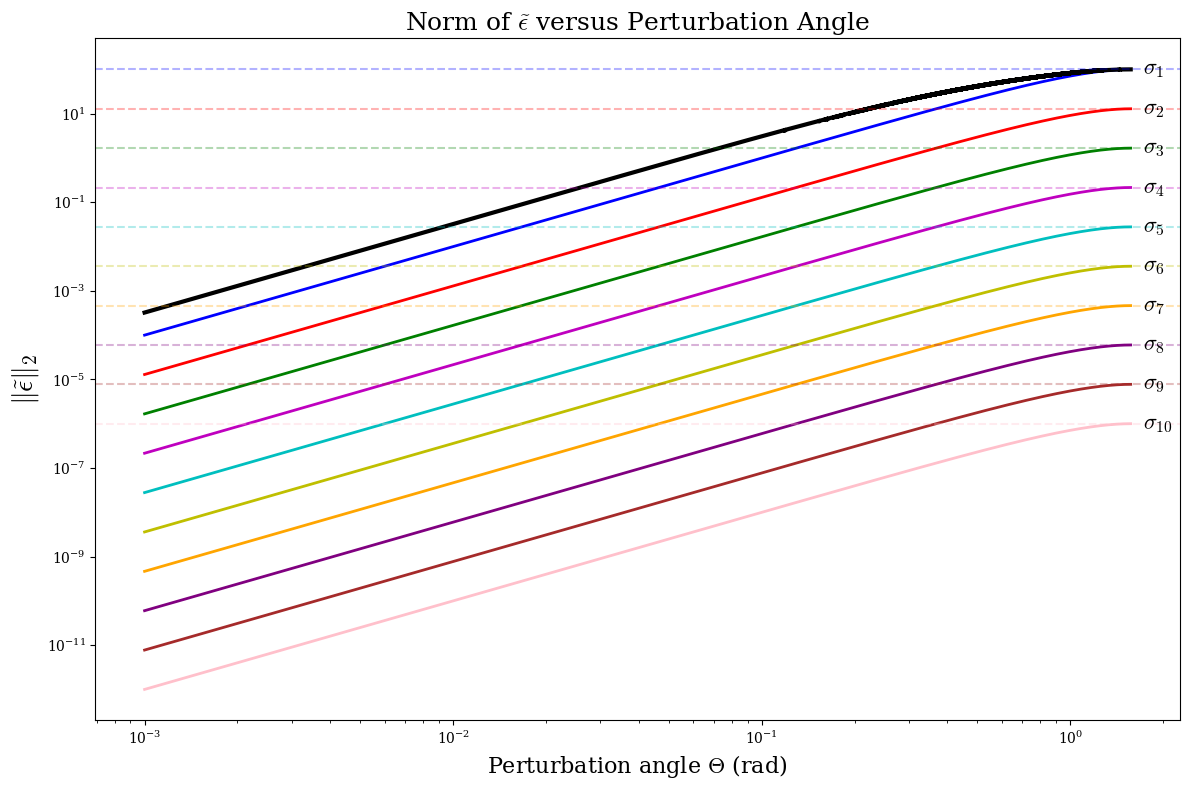


SUMMARY OF CHECKPOINT ANALYSIS

Column 0 (σ = 1.00e+02):
         θ         Norm     cos(θ)    U^TV[0,0]
--------------------------------------------------
  0.001000 9.999997e-05   1.000000     1.000000
  0.393390 1.469356e+01   0.923615    -0.923615
  0.785859 5.004608e+01   0.706781     0.706781
  1.178328 8.537163e+01   0.382471    -0.382471
  1.570796 1.000000e+02   0.000000     0.000000

Column 4 (σ = 2.78e-02):
         θ         Norm     cos(θ)    U^TV[4,4]
--------------------------------------------------
  0.001000 2.782558e-08   1.000000     1.000000
  0.393390 4.088572e-03   0.923615     0.923615
  0.785859 1.392562e-02   0.706781     0.706781
  1.178328 2.375516e-02   0.382471     0.382471
  1.570796 2.782559e-02   0.000000    -0.000000

Column 9 (σ = 1.00e-06):
         θ         Norm     cos(θ)    U^TV[9,9]
--------------------------------------------------
  0.001000 1.000053e-12   1.000000     1.000000
  0.393390 1.469356e-07   0.923615    -0.923615
  0.785859 5.0046

In [1]:
import numpy as np 
import scipy
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",  
    "font.family": "serif",
    "font.serif": ["DejaVu Serif", "Times New Roman", "serif"]  
})

n, r = 20, 10
rng = np.random.default_rng(42)

# Create U and singular values
U_A, _ = scipy.linalg.qr(rng.standard_normal((n, r)), mode='economic')
sing_vals_A = np.logspace(-6, 2, r)[::-1]
S_A = np.diag(sing_vals_A)

# Create full n BY n diagonal matrix S_full (padded with zeros)
S_full = np.zeros((n, n))
S_full[:r, :r] = S_A

# Extend U_A to full n by n orthogonal matrix
U_full, _ = scipy.linalg.qr(np.hstack([U_A, rng.standard_normal((n, n-r))]))

print(f"Singular values: {sing_vals_A}")

def perturb_column_and_compute_norm_with_UtV(U_A, S_A, col_idx, theta, rng, debug=False):
    """
    Perturb a specific column of U_A and compute ||(I - U^T V)S||_2
    Also returns the U^T V matrix
    """
    # make z (orthogonal to span(U_A) normed)
    z = rng.standard_normal((U_A.shape[0], 1))
    z -= U_A @ (U_A.T @ z)
    z /= np.linalg.norm(z)
    
    # Perturb the specified column
    V_A = U_A.copy()
    c, s = np.cos(theta), np.sin(theta)
    V_A[:, [col_idx]] = c * U_A[:, [col_idx]] + s * z
    V_A, _ = scipy.linalg.qr(V_A, mode="economic")
    
    # Compute S - U^TV S U^TV
    r = U_A.shape[1]
    UtV_rr = U_A.T @ V_A  # This is r×r
    I_r = np.eye(r)
    I_minus_UtV_rr = I_r - UtV_rr
    I_minus_UtV_S_rr = S_A - UtV_rr @ S_A @ UtV_rr
    norm_result = np.linalg.norm(I_minus_UtV_S_rr, ord=2)############################################
    
    if debug:
        print(f"\nColumn {col_idx} perturbation:")
        print(f"U^T V diagonal elements: {np.diag(UtV_rr)}")
        print(f"(I - U^T V)[{col_idx},{col_idx}] = {I_minus_UtV_rr[col_idx,col_idx]:.6f}")
        print(f"||(I - U^T V)||_2 = {np.linalg.norm(I_minus_UtV_rr, ord=2):.6f}")
    
    return norm_result, UtV_rr

def perturb_column_and_compute_norm(U_A, S_A, col_idx, theta, rng, debug=False):
    """Original function for compatibility"""
    norm_result, _ = perturb_column_and_compute_norm_with_UtV(U_A, S_A, col_idx, theta, rng, debug)
    return norm_result

def perturb_all_columns_and_compute_norm(U_A, S_A, theta, rng, debug=False):
    """
    Perturb all the columns of U_A by angle theta toward the same z, then compute ||S - U^T V S U^TV||_2
    """
    n, r = U_A.shape
    z = rng.standard_normal((n, 1))
    z -= U_A @ (U_A.T @ z)
    z /= np.linalg.norm(z)

    V_A = U_A.copy()
    c, s = np.cos(theta), np.sin(theta)
    # Perturb every column by the same angle \Theta
    for j in range(r):
        V_A[:, [j]] = c * U_A[:, [j]] + s * z
    V_A, _ = scipy.linalg.qr(V_A, mode="economic")

    r = U_A.shape[1]
    UtV_rr = U_A.T @ V_A
    I_r = np.eye(r)
    I_minus_UtV_rr = I_r - UtV_rr
    I_minus_UtV_S_rr = S_A - UtV_rr @ S_A @ UtV_rr
    norm_result = np.linalg.norm(I_minus_UtV_S_rr, ord=2)

    # Debugging info
    if debug:
        print(r"\nALL COLUMNS PERTURBED by $\Theta$ " f" ={theta:.4f}")
        print(f"U^T V diagonal elements: {np.diag(UtV_rr)}")
        print(f"||(S - U^T V S U^TV||_2 = {np.linalg.norm(I_minus_UtV_rr, ord=2):.6f}")

    return norm_result

def print_utv_matrix(UtV, col_idx, theta, norm_val, sing_val):
    # Helper function to print U^T V matrix with formatting
    print(f"\n{'='*60}")
    print(f"Column {col_idx} at " r"$\Theta$" f"= {theta:.6f}")
    print(f"Norm = {norm_val:.6e}, Singular value = {sing_val:.6e}")
    print(f"{'='*60}")
    
    print("\nFull U^T V matrix:")
    print("-"*50)
    
    # Print the full matrix
    for row in range(r):
        row_str = "["
        for col in range(r):
            val = UtV[row, col]
            if abs(val) < 1e-10:
                row_str += f" {0:7.4f}"
            else:
                row_str += f" {val:7.4f}"
        row_str += " ]"
        print(row_str)
    
    print("\nDiagonal elements of U^T V:")
    print(f"{np.diag(UtV)}")
    
    # Check if it matches expected form
    expected_diag = np.ones(r)
    expected_diag[col_idx] = np.cos(theta)
    diag_diff = np.abs(np.diag(UtV) - expected_diag)
    print(f"\nExpected diagonal: {expected_diag}")
    print(f"Max diagonal deviation from expected: {np.max(diag_diff):.6e}")
    off_diag_mask = np.ones((r, r), dtype=bool)
    np.fill_diagonal(off_diag_mask, False)
    max_off_diag = np.max(np.abs(UtV[off_diag_mask]))
    print(f"Max off-diagonal element magnitude: {max_off_diag:.6e}")

# Define which columns to analyse
columns_to_analyze = list(range(r))  # All columns here

thetas = np.linspace(1e-3, np.pi / 2, 20000)

# Define checkpoints - 5 evenly spaced points in the range of Theta
checkpoint_indices = np.linspace(0, len(thetas)-1, 5, dtype=int)
checkpoint_thetas = thetas[checkpoint_indices]

print(f"\nCheckpoint theta values: {checkpoint_thetas}")

# Store results for each column
results = {}
colors = ['b', 'r', 'g', 'm', 'c', 'y', 'orange', 'purple', 'brown', 'pink']

# Analyse selected columns at checkpoints (showing first 3 columns for brevity)
columns_to_show_details = [0, 4, 9]  # First, middle, and last column


print(f"analysis of column: {columns_to_show_details}")


for i, col_idx in enumerate(columns_to_analyze):
    print(f"\nProcessing column {col_idx}...")
    norms = []
    actual_idx = col_idx if col_idx >= 0 else r + col_idx
    singular_value = sing_vals_A[actual_idx]
    
    for j, theta in enumerate(thetas):
        norm_val, UtV = perturb_column_and_compute_norm_with_UtV(U_A, S_A, col_idx, theta, rng, False)
        norms.append(norm_val)
        
        # Print detailed info at checkpoints for selected columns
        if col_idx in columns_to_show_details and j in checkpoint_indices:
            print_utv_matrix(UtV, col_idx, theta, norm_val, singular_value)
    
    results[col_idx] = norms

# Create plot
plt.figure(figsize=(12, 8))

norms_all = []
for j, theta in enumerate(thetas):
    debug = (j == 0)
    norm_val = perturb_all_columns_and_compute_norm(U_A, S_A, theta, rng, debug)
    norms_all.append(norm_val)

for i, col_idx in enumerate(columns_to_analyze):
    color = colors[i % len(colors)]
    actual_idx = col_idx if col_idx >= 0 else r + col_idx
    label = f'Column {col_idx} (σ = {sing_vals_A[actual_idx]:.2e})'
    plt.loglog(thetas, results[col_idx], color=color, linestyle='-', 
               label=label, linewidth=2)
    #plt.loglog(thetas, sing_vals_A[actual_idx] * thetas**2, color=color, 
              # linestyle=':', alpha=0.5, linewidth=2)
    """
    # Mark checkpoint locations for selected columns
    if col_idx in columns_to_show_details:
        checkpoint_norms = [results[col_idx][idx] for idx in checkpoint_indices]
        plt.plot(checkpoint_thetas, checkpoint_norms, 'o', color=color, 
                markersize=8, markeredgecolor='black', markeredgewidth=1)"""

plt.loglog(thetas, norms_all, color='k', label='All columns perturbed', linewidth=3)

# plotting gradients
print("\n" + "="*60)
print("GRADIENT ANALYSIS")
print("="*60)

# Calculate gradients log-log space
log_thetas = np.log10(thetas)
gradients = {}

for i, col_idx in enumerate(columns_to_analyze):
    log_norms = np.log10(results[col_idx])
    # Calculate gradient using finite differences
    gradient = np.gradient(log_norms, log_thetas)
    gradients[col_idx] = gradient
    
    # Print average gradient for each column
    avg_gradient = np.mean(gradient)
    actual_idx = col_idx if col_idx >= 0 else r + col_idx
    print(f"Column {col_idx} (σ = {sing_vals_A[actual_idx]:.2e}): avg gradient = {avg_gradient:.3f}")
    """
    # Only plot gradient if it's finite and reasonable
    if np.isfinite(avg_gradient) and abs(avg_gradient) < 100:
        color = colors[i % len(colors)]
        plt.loglog(thetas, np.full_like(thetas, abs(avg_gradient)), color=color, linestyle='--', 
                   alpha=0.7, linewidth=1, 
                   label=f'Grad Col {col_idx} (slope={avg_gradient:.2f})')"""


# Calculate gradient for all columns perturbed
log_norms_all = np.log10(norms_all)
gradient_all = np.gradient(log_norms_all, log_thetas)
avg_gradient_all = np.mean(gradient_all)
print(f"All columns perturbed: avg gradient = {avg_gradient_all:.3f}")

"""
# Only plot if finite and reasonable
if np.isfinite(avg_gradient_all) and abs(avg_gradient_all) < 100:
    plt.loglog(thetas, np.full_like(thetas, abs(avg_gradient_all)), color='k', linestyle='--', 
               alpha=0.7, linewidth=2, label=f'Grad All columns (slope={avg_gradient_all:.2f})')"""

plt.xlabel(r'Perturbation angle $\Theta$ (rad)', fontsize=16)
plt.ylabel(r'$\|\tilde{\epsilon}\|_2$', fontsize=20)
plt.title(r'Norm of $\tilde{\epsilon}$ versus Perturbation Angle', fontsize=18)
#plt.legend(fontsize=11, ncol=2)####################################################
plt.grid(False)

# Add reference lines for all singular values being analyzed
for i, col_idx in enumerate(columns_to_analyze):
    actual_idx = col_idx if col_idx >= 0 else r + col_idx
    plt.axhline(y=sing_vals_A[actual_idx], color=colors[i % len(colors)], 
                linestyle='--', alpha=0.3)
    # Add sigma label at the right edge of the plot
    plt.text(thetas[-1] * 1.1, sing_vals_A[actual_idx], 
             f'$\\sigma_{{{actual_idx+1}}}$', 
             #color=colors[i % len(colors)], 
             fontsize=16, 
             verticalalignment='center',
             horizontalalignment='left')

# Add vertical lines at checkpoints
#for theta_checkpoint in checkpoint_thetas:
   # plt.axvline(x=theta_checkpoint, color='gray', linestyle=':', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SUMMARY OF CHECKPOINT ANALYSIS")
print("="*80)

for col_idx in columns_to_show_details:
    actual_idx = col_idx if col_idx >= 0 else r + col_idx
    print(f"\nColumn {col_idx} (σ = {sing_vals_A[actual_idx]:.2e}):")
    print(f"{'θ':>10} {'Norm':>12} {'cos(θ)':>10} {'U^TV[{},{}]'.format(col_idx,col_idx):>12}")
    print("-"*50)
    
    for idx in checkpoint_indices:
        theta = thetas[idx]
        norm_val, UtV = perturb_column_and_compute_norm_with_UtV(U_A, S_A, col_idx, theta, rng, False)
        utv_diag = UtV[col_idx, col_idx]
        print(f"{theta:10.6f} {norm_val:12.6e} {np.cos(theta):10.6f} {utv_diag:12.6f}")

In [ ]:
import numpy as np
import scipy.linalg as la
from numpy.linalg import pinv, norm, inv

def create_random_matrix(rows, cols, seed=None):
    """Create a random Gaussian matrix"""
    if seed is not None:
        np.random.seed(seed)
    return np.random.randn(rows, cols)

def create_rank_r_matrix(n, r, seed=None):
    """Create an n×n matrix with rank r"""
    if seed is not None:
        np.random.seed(seed)
    B = np.random.randn(n, r)
    return B @ B.T

def slim_qr_decomposition(AX, r):
    """
    Perform slim QR decomposition: AX = QR where Q is n×r, R is r×s
    Q has orthonormal columns spanning the column space of AX
    """
    n, s = AX.shape
    
    # Use economic QR decomposition
    Q_full, R_full = la.qr(AX, mode='economic')
    
    # For slim QR, take first r columns of Q and first r rows of R
    Q = Q_full[:, :r]    # n × r (orthonormal columns)
    R = R_full[:r, :]    # r × s (upper triangular)
    
    return Q, R

def verify_simplification(n=10, s=8, r=5, seed=42):
    """
    Verify that ||(X^T Q)^+ (X^T A X) (X^T A X)^+ (X^T D)|| = ||(X^T Q)^+ (X^T D)||
    """
    print("=== Matrix Expression Simplification Verification ===")
    print(f"Dimensions: n={n}, s={s}, r={r}")
    
    # Create matrices
    np.random.seed(seed)
    X = create_random_matrix(n, s)  # Gaussian sketching matrix
    A = create_rank_r_matrix(n, r)  # Rank-r matrix
    D = create_random_matrix(n, 3)  # Test matrix
    
    print(f"X shape: {X.shape}")
    print(f"A shape: {A.shape}, estimated rank: {np.linalg.matrix_rank(A)}")
    print(f"D shape: {D.shape}")
    
    # Compute AX and perform slim QR decomposition
    AX = A @ X
    print(f"AX shape: {AX.shape}, rank: {np.linalg.matrix_rank(AX)}")
    
    # Slim QR: QR = AX (taking first r columns)
    Q, R = slim_qr_decomposition(AX, r)
    
    print(f"Q shape: {Q.shape} (should be {n}×{r})")
    print(f"R shape: {R.shape} (should be {r}×{s})")
    print(f"R condition number: {np.linalg.cond(R):.2e}")
    
    # Verify QR decomposition quality
    QR_reconstruction = Q @ R
    qr_error = norm(QR_reconstruction - AX, 'fro')
    print(f"QR reconstruction error: {qr_error:.2e}")
    
    # Key matrices for the expression
    XtQ = X.T @ Q        # s × r
    XtAX = X.T @ A @ X   # s × s
    XtD = X.T @ D        # s × 3
    
    print(f"\nKey matrices:")
    print(f"X^T Q shape: {XtQ.shape}")
    print(f"X^T A X shape: {XtAX.shape}")
    print(f"X^T D shape: {XtD.shape}")
    
    # Compute pseudoinverses
    XtQ_pinv = pinv(XtQ)     # r × s (since XtQ is s×r with full column rank)
    XtAX_pinv = pinv(XtAX)   # s × s
    R_pinv = pinv(R)         # s × r (since R is r×s)
    
    print(f"(X^T Q)^+ shape: {XtQ_pinv.shape}")
    print(f"R^+ shape: {R_pinv.shape}")
    
    # Verify key relationship: X^T A X = X^T Q R (should be exact now!)
    XtQR = XtQ @ R  # s × r @ r × s = s × s
    print(f"X^T Q R shape: {XtQR.shape}")
    
    substitution_error = norm(XtAX - XtQR, 'fro')
    print(f"X^T A X = X^T Q R error: {substitution_error:.2e}")
    
    # Test the key identity: (X^T Q R)^+ = R^+ (X^T Q)^+
    XtQR_pinv_direct = pinv(XtQR)
    XtQR_pinv_via_reversal = R_pinv @ XtQ_pinv
    
    identity_error = norm(XtQR_pinv_direct - XtQR_pinv_via_reversal, 'fro')
    print(f"(X^T Q R)^+ = R^+ (X^T Q)^+ error: {identity_error:.2e}")
    
    # Now test the main simplification
    print(f"\n=== Testing Main Simplification ===")
    
    # Original expression: (X^T Q)^+ (X^T A X) (X^T A X)^+ (X^T D)
    # We need to be careful about the substitution here
    # Since X^T A X might not exactly equal X^T Q R, let's use the projection
    
    # Method 1: Direct computation with original X^T A X
    original_expr = XtQ_pinv @ XtAX @ XtAX_pinv @ XtD
    
    # Method 2: Simplified expression
    simplified_expr = XtQ_pinv @ XtD
    
    # Method 3: Using the theoretical substitution X^T A X = X^T Q R (now exact!)
    theoretical_expr = XtQ_pinv @ XtQR @ XtQR_pinv_direct @ XtD
    
    print(f"Original expression shape: {original_expr.shape}")
    print(f"Simplified expression shape: {simplified_expr.shape}")
    print(f"Theoretical expression shape: {theoretical_expr.shape}")
    
    # Compare norms
    orig_norm = norm(original_expr, 'fro')
    simp_norm = norm(simplified_expr, 'fro')
    theo_norm = norm(theoretical_expr, 'fro')
    
    print(f"\nFrobenius norms:")
    print(f"Original: {orig_norm:.6f}")
    print(f"Simplified: {simp_norm:.6f}")
    print(f"Theoretical: {theo_norm:.6f}")
    
    # Check differences
    diff_orig_simp = norm(original_expr - simplified_expr, 'fro')
    diff_theo_simp = norm(theoretical_expr - simplified_expr, 'fro')
    
    print(f"\nDifferences:")
    print(f"||Original - Simplified||_F: {diff_orig_simp:.2e}")
    print(f"||Theoretical - Simplified||_F: {diff_theo_simp:.2e}")
    print(f"Relative error (orig vs simp): {diff_orig_simp/orig_norm:.2e}")
    print(f"Relative error (theo vs simp): {diff_theo_simp/theo_norm:.2e}")
    
    # Test the core algebraic identity: (X^T Q)^+ (X^T Q R) (X^T Q R)^+ = (X^T Q)^+
    print(f"\n=== Testing Core Identity ===")
    identity_lhs = XtQ_pinv @ XtQR @ XtQR_pinv_direct
    identity_rhs = XtQ_pinv
    
    core_identity_error = norm(identity_lhs - identity_rhs, 'fro')
    identity_rel_error = core_identity_error / norm(identity_rhs, 'fro')
    
    print(f"Core identity error: {core_identity_error:.2e}")
    print(f"Core identity relative error: {identity_rel_error:.2e}")
    
    # Also test if the reversal property holds: (X^T Q R)^+ = R^+ (X^T Q)^+
    reversal_error = norm(XtQR_pinv_direct - R_pinv @ XtQ_pinv, 'fro')
    reversal_rel_error = reversal_error / norm(XtQR_pinv_direct, 'fro')
    print(f"Reversal property error: {reversal_rel_error:.2e}")
    
    # Final verdict
    print(f"\n=== RESULTS ===")
    if identity_rel_error < 1e-10:
        print("✅ Core identity verified!")
        if diff_theo_simp / theo_norm < 1e-10:
            print("✅ SIMPLIFICATION WORKS!")
            print("   ||(X^T Q)^+ (X^T A X) (X^T A X)^+ (X^T D)|| = ||(X^T Q)^+ (X^T D)||")
        else:
            print("❌ Simplification fails in practice")
    else:
        print("❌ Core identity fails")
    
    if diff_orig_simp / orig_norm > 0.1:
        print("⚠️  Note: Original X^T A X may not be well-approximated by X^T Q R")
        print("   This is expected since we're only using r columns in slim QR")
    
    return {
        'original_norm': orig_norm,
        'simplified_norm': simp_norm,
        'difference': diff_orig_simp,
        'relative_error': diff_orig_simp / orig_norm,
        'core_identity_error': identity_rel_error
    }

if __name__ == "__main__":
    # Run verification
    results = verify_simplification(n=10, s=8, r=5, seed=42)
    
    print(f"\n=== Additional Test with Different Dimensions ===")
    results2 = verify_simplification(n=15, s=12, r=6, seed=123)

=== Matrix Expression Simplification Verification ===
Dimensions: n=10, s=8, r=5
X shape: (10, 8)
A shape: (10, 10), estimated rank: 5
D shape: (10, 3)
AX shape: (10, 8), rank: 5
Q shape: (10, 5) (should be 10×5)
R shape: (5, 8) (should be 5×8)
R condition number: 1.80e+01
QR reconstruction error: 2.32e-14

Key matrices:
X^T Q shape: (8, 5)
X^T A X shape: (8, 8)
X^T D shape: (8, 3)
(X^T Q)^+ shape: (5, 8)
R^+ shape: (8, 5)
X^T Q R shape: (8, 8)
X^T A X = X^T Q R error: 8.96e-14
(X^T Q R)^+ = R^+ (X^T Q)^+ error: 1.81e-15

=== Testing Main Simplification ===
Original expression shape: (5, 3)
Simplified expression shape: (5, 3)
Theoretical expression shape: (5, 3)

Frobenius norms:
Original: 5.121197
Simplified: 5.121197
Theoretical: 5.121197

Differences:
||Original - Simplified||_F: 7.63e-15
||Theoretical - Simplified||_F: 7.36e-15
Relative error (orig vs simp): 1.49e-15
Relative error (theo vs simp): 1.44e-15

=== Testing Core Identity ===
Core identity error: 2.45e-15
Core identity r

: 